In [1]:
import numpy as np

In [2]:
# Imports for plots

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

# Imports froom standard packages
from astropy.io import fits
import numpy as np

# Local imports
from simulation_utils import load_simu, add_noise

In [99]:
def get_trace_center(aperture):
    """
    *** To use when the trace centroid is not available ***
    Return the center of the trace given an aperture estimate.
    The aperture estimate could use the data directly.
    Parameter
    ---------
    aperture: 2d array
        estimate of the aperture.
    Output
    ------
    (columns, aperture center)
    """
    # Valid columns
    col = np.where((aperture > 0.).any(axis=0))[0]
    
    # Get rows position for valid columns
    rows = np.indices(aperture.shape)[0][:, col]
    
    # Convert aperture to weights for valid columns
    weights = aperture[:, col]
    weights /= weights.sum(axis=0)
    
    # Compute center of mass to find the center
    center = (rows*weights).sum(axis=0)
    
    return col, center


def get_aperture_weights(aperture, n_pix=20):
    """
    Return the weights of a box aperture given the aperture
    profile and the width of the box in pixels.
    All pixels will have the same weights except at the
    ends of the aperture.
    Parameters
    ----------
    aperture: 2d array
        2d map of the aperture. Used to find the trace center
        with the function `get_trace_center`.
    n_pix: float, optional
        width of the extraction box in pixels. Default is 20 pixels.
    """
    # Find trace center
    cols, center = get_trace_center(aperture)
    # Save the shape of aperture with good columns
    shape = (aperture.shape[0], len(cols))
    # Box limits for all cols (+/- n_pix/2)
    row_lims = [center - n_pix/2, center + n_pix/2]
    row_lims = np.array(row_lims).T
    # Compute weights
    # For max lim:
    # w = center + n_pix/2 - (rows - 0.5)
    # For min lim:
    # w = rows + 0.5 - center + n_pix/2
    rows = np.indices(shape)[0]
    weights = rows[:, :, None] - row_lims[None, :, :]
    weights *= np.array([1, -1])
    weights += 0.5
    # Between 0 and 1
    weights = np.clip(weights, 0, 1)
    # Keep min weight
    weights = weights.min(axis=-1)
    # Normalize
    weights /= weights.sum(axis=0)
    # Return with the same shape as aperture and
    # with zeros where the aperture is not define
    out = np.zeros(aperture.shape, dtype=float)
    out[:, cols] = weights
    return out

def get_box_weights_old(cols, centroid, n_pix, shape):
    """
    Return the weights of a box aperture given the centroid
    and the width of the box in pixels.
    All pixels will have the same weights except at the
    ends of the box aperture.
    Parameters
    ----------
    cols: 1d array
        Columns positions
    centroid: 1d array
        Position of the centroid (in rows). Same shape as `cols`
    n_pix: float
        width of the extraction box in pixels.
    shape: 2 integers tuple
        shape of the output image. (n_row, n_column)
    Ouput
    -----
    2d image of the box weights
    """
    # Box limits for all cols (+/- n_pix/2)
    row_lims = [centroid - n_pix/2, centroid + n_pix/2]
    row_lims = np.array(row_lims).T
    # Compute weights
    # For min lim:
    # w = rows + 0.5 - centroid + n_pix/2
    # For max lim:
    # w = centroid + n_pix/2 - (rows - 0.5)
    # In other words:
    # For min lim
    # w = (rows - centroid + n_pix/2) + 0.5
    # For max lim
    # w = -(rows - centroid - n_pix/2) + 0.5
    # The lines below are equivalent
    rows = np.indices((shape[0], len(cols)))[0]
    weights = rows[:, :, None] - row_lims[None, :, :]
    weights *= np.array([1, -1])
    weights += 0.5
    
    # Force between 0 and 1 since the values out of the
    # box will have values below 0
    weights = np.clip(weights, 0, 1)
    
    # Keep min weight
    weights = weights.min(axis=-1)
    
    # Normalize
    weights /= weights.sum(axis=0)
    
    # Return with the specified shape
    # with zeros where the box is not define
    out = np.zeros(shape, dtype=float)
    out[:, cols] = weights
    
    return out

def get_box_weights(cols, centroid, n_pix, shape):
    """
    Return the weights of a box aperture given the centroid
    and the width of the box in pixels.
    All pixels will have the same weights except at the
    ends of the box aperture.
    Parameters
    ----------
    cols: 1d array, integer
        Columns index positions. Useful if the centroid is defined for 
        specific columns or a subrange of columns.
    centroid: 1d array
        Position of the centroid (in rows). Same shape as `cols`
    n_pix: float
        full width of the extraction box in pixels.
    shape: 2 integers tuple
        shape of the output image. (n_row, n_column)
    Ouput
    -----
    2d image of the box weights
    """
    # Row centers of all pixels
    rows = np.indices((shape[0], len(cols)))[0]
    
    # Pixels that are entierly inside the box are set to one
    cond = (rows <= (centroid - 0.5 + n_pix/2))
    cond &= ((centroid + 0.5 - n_pix/2) <= rows)
    weights = cond.astype(float)
    
    # Upper bound
    cond = (centroid - 0.5 + n_pix/2) < rows
    cond &= (rows < (centroid + 0.5 + n_pix/2))
    weights[cond] = (centroid + n_pix/2 - (rows - 0.5))[cond]
    
    # Lower bound
    cond = (rows < (centroid + 0.5 - n_pix/2))
    cond &= ((centroid - 0.5 - n_pix/2) < rows)
    weights[cond] = (rows + 0.5 - (centroid - n_pix/2))[cond]
    
    # Return with the specified shape
    # with zeros where the box is not define
    out = np.zeros(shape, dtype=float)
    out[:, cols] = weights
    
    return out


def box_extract(data, box_weights, lam_col=None, cols=None, mask=None):
    '''
    Make a box extraction
    Parameters
    ----------
    data: 2d array of shape (n_row, n_columns)
        scidata
    box_weights: 2d array, same shape as data
        pre-computed weights for box extraction.
    lam_col: 1d array of shape (n_columns)
        wavelength associated with each columns. If not given,
        the column position is taken as ordinates.
    cols: numpy valid index
        Which columns to extract
    mask: 2d array, boolean, same shape as data
        masked pixels
    Output
    ------
    (wavelengths or column position, spectrum)
    '''
    # Use all columns if not specified
    if cols is None:
        cols = slice(None)

    # Define mask if not given
    if mask is None:
        # False everywhere
        mask = np.zeros(data.shape, dtype=bool)

    # Use pixel position if no wavelenghts are given
    if lam_col is None:
        lam_col = np.arange(data.shape[1])

    # Make a copy of arrays with only needed columns
    # so it is not modified outside of the function
    data = data[:, cols].copy()
    box_weights = box_weights[:, cols].copy()
    mask = mask[:, cols].copy()

    # Initialize the output with nans
    out = np.ones_like(lam_col) * np.nan

    # Mask potential nans in data
    mask_nan = np.isnan(data)

    # Combine with user specified mask
    mask = (mask_nan | mask)

    # Apply to weights
    box_weights[mask_nan] = np.nan

    # Normalize only valid columns
    out = np.nansum(box_weights*data, axis=0)    
    
    # Return sorted with the associated wavelength
    idx_sort = np.argsort(lam_col)
    out = (lam_col[idx_sort], out[idx_sort])

    return out

# flux total
# somme des variances poisson
# somme read noise
# somme variance flat field
# flux bkgrnd


In [4]:
tilted = False
DEFAULT_PATH = '../jwst-mtl/SOSS/extract/'
DEFAULT_REF_FILES = {'wv_1': 'Ref_files/wavelengths_m1.fits',
                     'wv_2': 'Ref_files/wavelengths_m2.fits',
                     'P_1': 'Ref_files/spat_profile_m1.fits',
                     'P_2': 'Ref_files/spat_profile_m2.fits'}

# Read relevant files
wv_1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_1"])[0].data
wv_2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_2"])[0].data
P1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_1"])[0].data.squeeze()
P2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_2"])[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

if not tilted:
    # Remove the tilt from wv maps
    wv_1 = np.tile(wv_1[50,:], (256, 1))
    wv_2 = np.tile(wv_2[50,:], (256, 1))

In [5]:
simu = load_simu("../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_cutker.fits", order=1, noisy=False)

In [6]:
simu

{'grid': array([0.55028933, 0.55033624, 0.55038314, ..., 2.99890133, 2.99900319,
        2.99910505]),
 'f_k': array([4.72029320e+17, 4.71639018e+17, 4.71318327e+17, ...,
        0.00000000e+00, 8.29292343e-10, 0.00000000e+00]),
 'grid_c1': array([0.84147497, 0.84152173, 0.84156849, ..., 2.83173548, 2.83183674,
        2.83193799]),
 'f_c1': array([1.17800818e+17, 1.17979118e+17, 1.18146174e+17, ...,
        2.26338122e+15, 2.26308541e+15, 2.26278729e+15]),
 'grid_c2': array([0.55295728, 0.55300335, 0.55304943, ..., 1.40956877, 1.40961534,
        1.40966191]),
 'f_c2': array([4.62734520e+17, 4.63541227e+17, 4.63950979e+17, ...,
        2.79486828e+16, 2.79452452e+16, 2.79417993e+16]),
 'data': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])}

In [40]:
data = simu['data']
aperture = data.copy()
aperture[np.isnan(aperture)] = 0

<IPython.core.display.Javascript object>


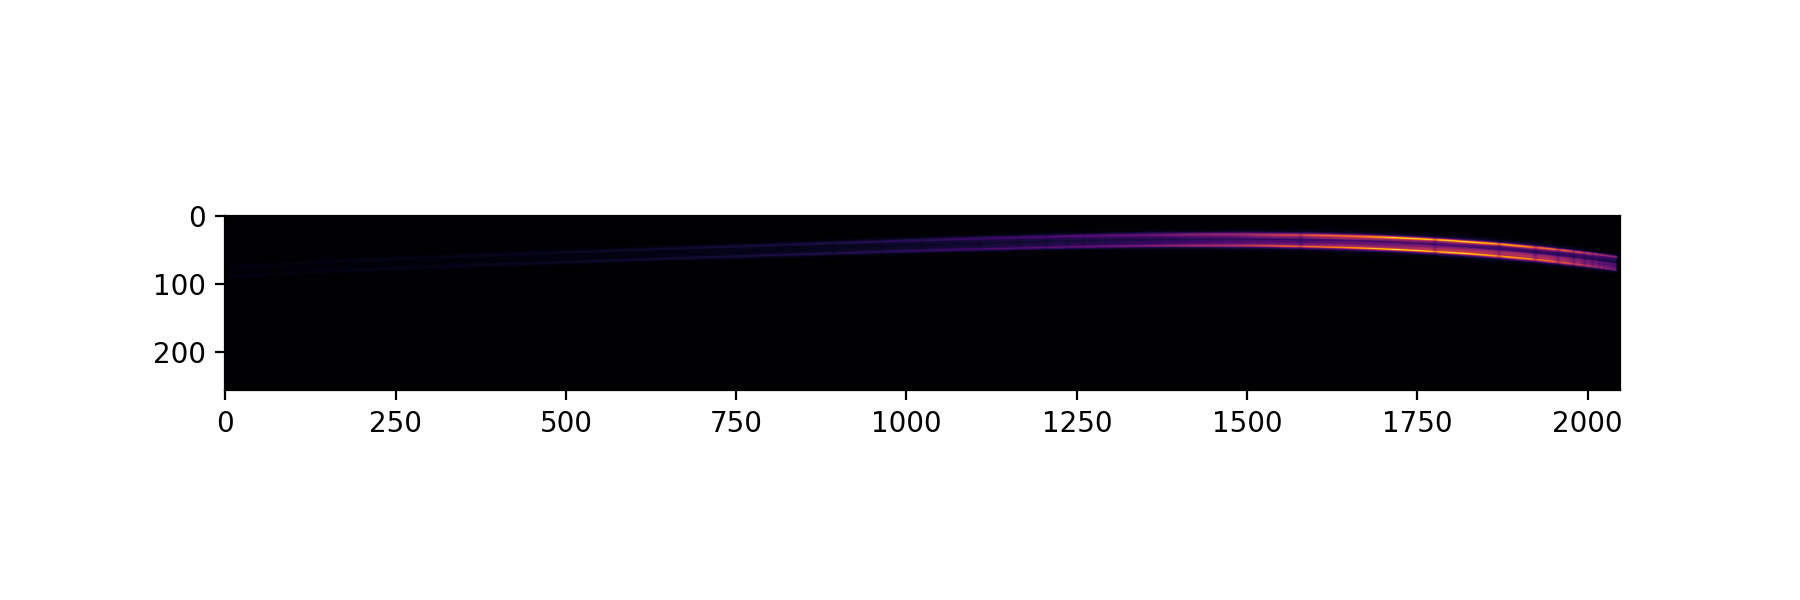

In [41]:
plt.imshow(aperture)

In [42]:
good_cols= np.where(~np.isnan(data).all(axis=0))[0]

In [43]:
aperture = aperture[:, good_cols]

In [44]:
centroid = get_trace_center(aperture)[1]

In [95]:
box_weights = get_box_weights(good_cols, centroid, 20, data.shape)

<IPython.core.display.Javascript object>


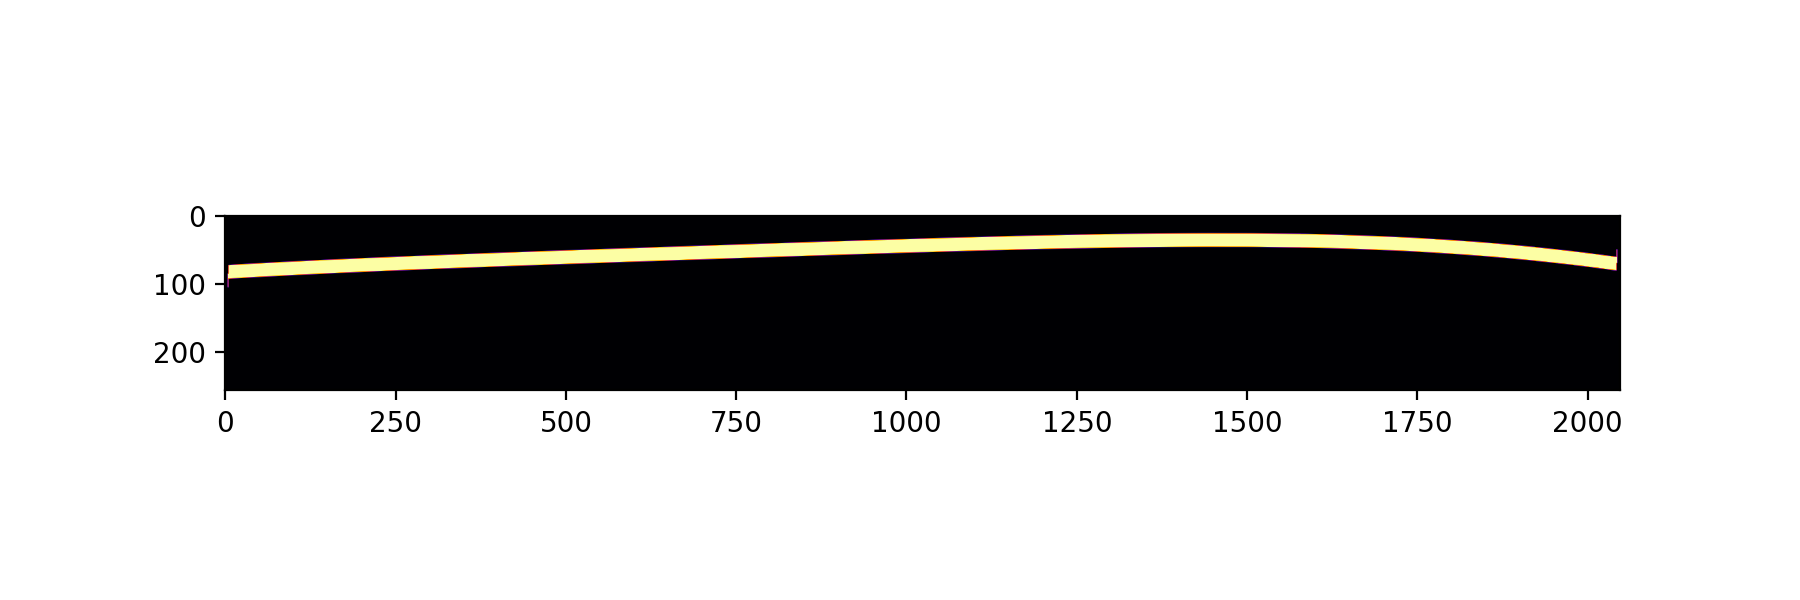

In [97]:
plt.imshow(box_weights)

In [103]:
x, y = box_extract(data, box_weights, mask=~np.isfinite(data))

<IPython.core.display.Javascript object>


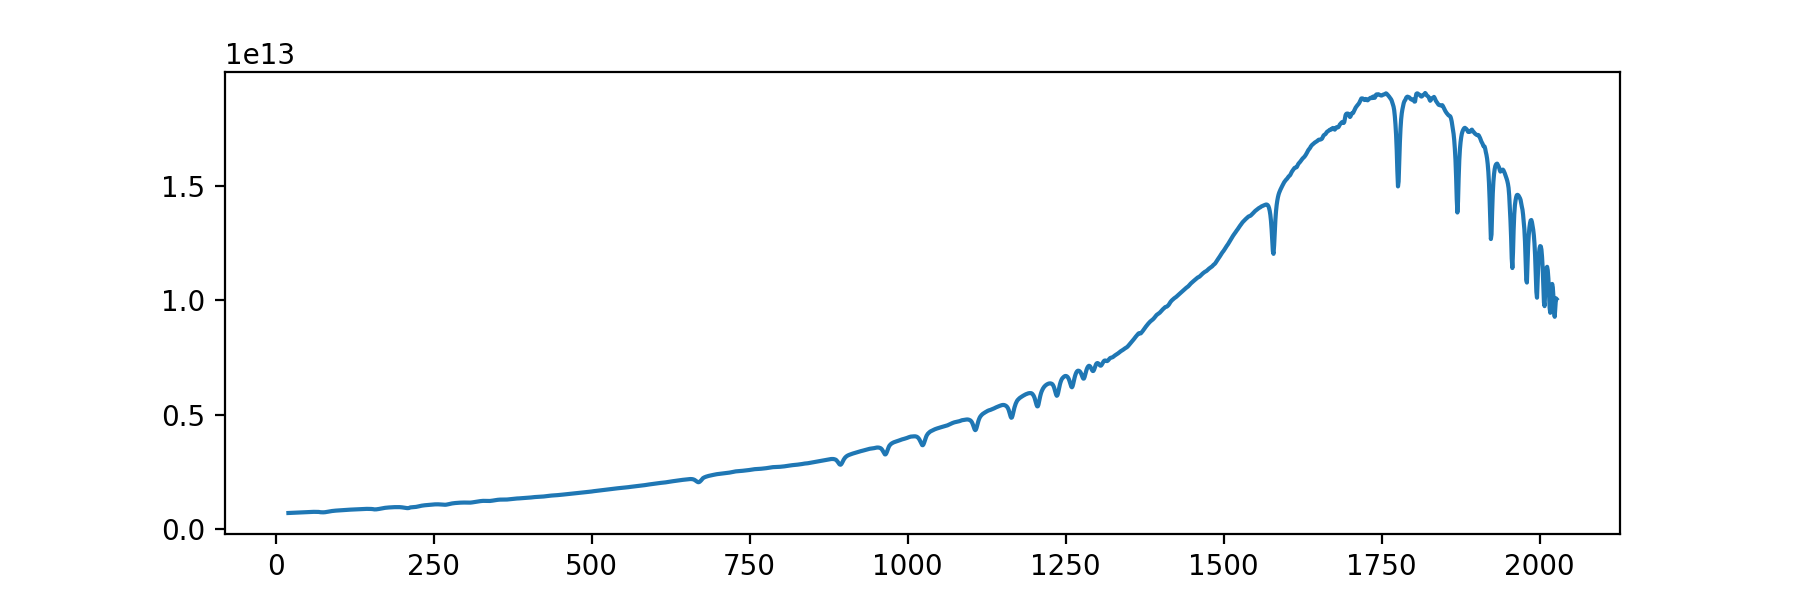

In [104]:
plt.plot(x[20:-20], y[20:-20])